In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [18]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

In [4]:
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
    )

In [5]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y : {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y : torch.Size([64]) torch.int64


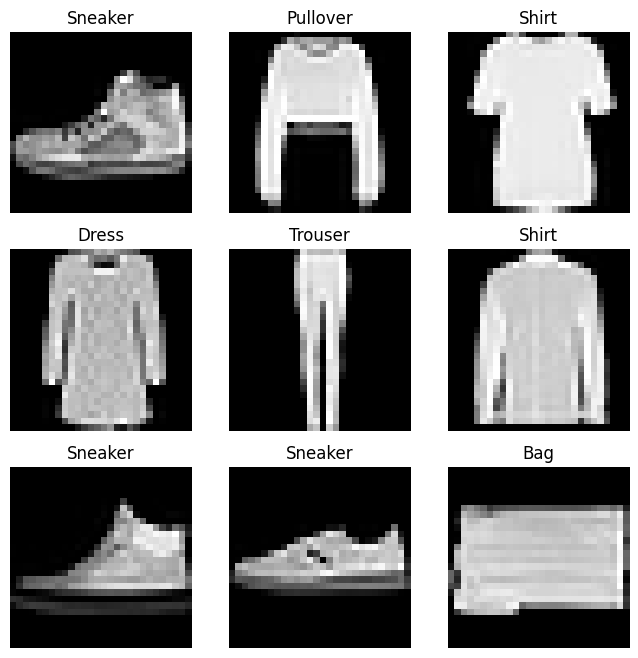

In [6]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")

using cuda device


In [8]:
class NeuralNets(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNets().to(device)
print(model)

NeuralNets(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1)*len(x)
            print(f"Loss: {loss : >7f} [{current: >5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batch
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
 -------------------------------------------
Loss: 2.306844 [   64/60000]
Loss: 2.291724 [ 6464/60000]
Loss: 2.276131 [12864/60000]
Loss: 2.280634 [19264/60000]
Loss: 2.254990 [25664/60000]
Loss: 2.231696 [32064/60000]
Loss: 2.243206 [38464/60000]
Loss: 2.206137 [44864/60000]
Loss: 2.199018 [51264/60000]
Loss: 2.181763 [57664/60000]
Test Error: 
 Accuracy: 40.4%, Avg loss: 2.168826 

Epoch 2
 -------------------------------------------
Loss: 2.176952 [   64/60000]
Loss: 2.165549 [ 6464/60000]
Loss: 2.111195 [12864/60000]
Loss: 2.137022 [19264/60000]
Loss: 2.085678 [25664/60000]
Loss: 2.023031 [32064/60000]
Loss: 2.063663 [38464/60000]
Loss: 1.978770 [44864/60000]
Loss: 1.978096 [51264/60000]
Loss: 1.925604 [57664/60000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 1.913995 

Epoch 3
 -------------------------------------------
Loss: 1.944473 [   64/60000]
Loss: 1.911057 [ 6464/60000]
Loss: 1.799417 [12864/60000]
Loss: 1.849119 [19264/60000]
Loss: 1.732553 [25664/60000]
Loss: 1.6830

In [15]:
torch.save(model.state_dict(), "model.pth")
print("Saved Pytorch model state to model.pth")

Saved Pytorch model state to model.pth


In [17]:
model = NeuralNets().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [19]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = testing_data[0][0], testing_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
